Imprts et Option

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 200)

Chargement des données brutes

In [83]:
# Adapter le chemin à ton environnement
df = pd.read_csv("../DATA/annonces_france.csv")

df.head()

,prix,surface,pieces,adresse,type_bien,departement_nom,departement_code
0,135 000,42,2.0,Valserhone (01200),Appartement,Ain,01
1,71 000,100,2.0,Virieu-le-Grand (01510),Maison,Ain,01
2,320 000,270,15.0,Sud Ouest Belley (01300),Maison,Ain,01
3,815 000,327,7.0,Sulignat (01400),Maison,Ain,01
4,509 000,81,4.0,RDC Cessy (01170),Appartement,Ain,01


In [84]:
df.shape

(5904, 7)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   prix              5904 non-null   object 
 1   surface           5904 non-null   object 
 2   pieces            5888 non-null   float64
 3   adresse           5751 non-null   object 
 4   type_bien         5904 non-null   object 
 5   departement_nom   5904 non-null   object 
 6   departement_code  5904 non-null   object 
dtypes: float64(1), object(6)
memory usage: 323.0+ KB


In [86]:
df.isna().sum()

prix                  0
surface               0
pieces               16
adresse             153
type_bien             0
departement_nom       0
departement_code      0
dtype: int64

Extraction Ville + Code postal depuis adresse

In [87]:
# Ville = adresse sans le code postal entre parenthèses
df["Ville"] = (
    df["adresse"]
    .str.replace(r"\s*\(\d{5}\)", "", regex=True)
    .str.strip()
)

# Code postal = les 5 chiffres entre parenthèses
df["Code_postal"] = df["adresse"].str.extract(r"\((\d{5})\)", expand=False)
df["Code_postal"] = df["Code_postal"].astype("string")

df[["adresse", "Ville", "Code_postal"]].head(10)

,adresse,Ville,Code_postal
0,Valserhone (01200),Valserhone,01200
1,Virieu-le-Grand (01510),Virieu-le-Grand,01510
2,Sud Ouest Belley (01300),Sud Ouest Belley,01300
3,Sulignat (01400),Sulignat,01400
4,RDC Cessy (01170),RDC Cessy,01170
5,RDC Nord Jassans-Riottier (01480),RDC Nord Jassans-Riottier,01480
6,Centre Ferney-Voltaire (01210),Centre Ferney-Voltaire,01210
7,Centre Ferney-Voltaire (01210),Centre Ferney-Voltaire,01210
8,Bressis-Neigeos Annecy (74000),Bressis-Neigeos Annecy,74000
9,Centre Ferney-Voltaire (01210),Centre Ferney-Voltaire,01210


Nettoyage de prix / surface + calcul de prix_m2

In [88]:
# Nettoyage de la colonne prix
df["prix"] = df["prix"].astype(str).str.replace(r"\s+", "", regex=True)
df["prix_num"] = pd.to_numeric(df["prix"], errors="coerce")

# Nettoyage de la colonne surface
df["surface"] = df["surface"].astype(str).str.replace(",", ".")
df["surface_num"] = pd.to_numeric(df["surface"], errors="coerce")

# Calcul du prix au m²
df["prix_m2"] = df["prix_num"] / df["surface_num"]

df[["prix_num", "surface_num", "prix_m2"]].describe()

,prix_num,surface_num,prix_m2
count,5.904000e+03,5895.000000,5895.000000
mean,3.045069e+05,99.590433,3624.336436
std,2.649154e+05,73.222166,2394.279885
min,6.000000e+03,9.000000,42.857143
25%,1.600000e+05,58.000000,1842.919986
50%,2.409000e+05,81.000000,3320.987654
75%,3.610000e+05,119.500000,4888.888889
max,5.300000e+06,730.000000,42380.952381


Filtrage des outliers sur prix_m2

In [89]:
# Filtre : on garde les biens avec prix_m2 <= 280000 €/m² pour pas avoir de valeurs aberrantes
df_vf = df[df["prix_m2"] <= 28000].copy()

df_vf["prix_m2"].describe()

count     5893.000000
mean      3611.768153
std       2295.177938
min         42.857143
25%       1842.391304
50%       3320.987654
75%       4886.666667
max      25454.968944
Name: prix_m2, dtype: float64

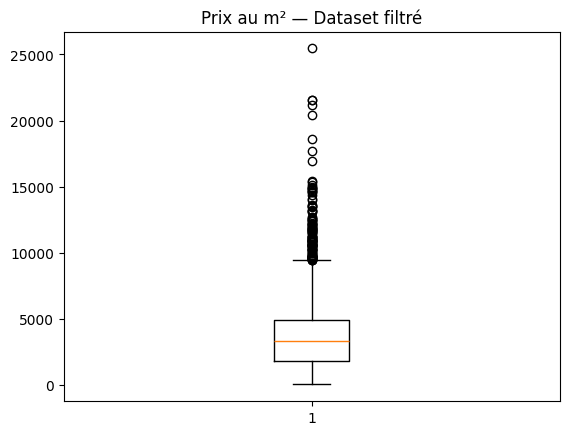

In [90]:
plt.boxplot(df_vf["prix_m2"].dropna())
plt.title("Prix au m² — Dataset filtré")
plt.show()

Vérification et suppression des doublons

In [91]:
print("Nombre de doublons :", df_vf.duplicated().sum())

df_vf = df_vf.drop_duplicates().copy()

print("Doublons restants après suppression :", df_vf.duplicated().sum())
print("Nouvelle shape :", df_vf.shape)


Nombre de doublons : 241
Doublons restants après suppression : 0
Nouvelle shape : (5652, 12)


Gestion des NaN (Ville, Code_postal)

In [92]:
# Remplir Ville manquante avec le nom du département
df_vf["Ville"] = df_vf["Ville"].fillna(df_vf["departement_nom"])

# Construire un Code_postal de secours pour les NaN
dep_str = df_vf["departement_code"].astype("string")
dep_for_cp = dep_str.replace({"2A": "20", "2B": "20"})  # Corse

df_vf["Code_postal"] = df_vf["Code_postal"].fillna(
    dep_for_cp.str.zfill(2) + "000"
)

df_vf[["Ville", "Code_postal"]].isna().sum()

Ville          0
Code_postal    0
dtype: int64

Nettoyage avancé du nom de ville

In [93]:
# Extraire la partie avant la parenthèse
df_vf["Ville_clean"] = df_vf["adresse"].str.extract(r"^(.*)\s*\(", expand=False)

# Enlever les mots parasites
mots_a_enlever = [
    "RDC", "Zone", "Quartier", "Secteur",
    "Ouest", "Est", "Nord", "Sud",
    "Urbaine", "Industrielle", "Forêt",
    "Proche", "Centre", "Ville"
]

for mot in mots_a_enlever:
    df_vf["Ville_clean"] = df_vf["Ville_clean"].str.replace(
        rf"\b{mot}\b", "", regex=True
    )

df_vf["Ville_clean"] = (
    df_vf["Ville_clean"]
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

df_vf[["adresse", "Ville_clean"]].head(10)

,adresse,Ville_clean
0,Valserhone (01200),Valserhone
1,Virieu-le-Grand (01510),Virieu-le-Grand
2,Sud Ouest Belley (01300),Belley
3,Sulignat (01400),Sulignat
4,RDC Cessy (01170),Cessy
5,RDC Nord Jassans-Riottier (01480),Jassans-Riottier
6,Centre Ferney-Voltaire (01210),Ferney-Voltaire
7,Centre Ferney-Voltaire (01210),Ferney-Voltaire
8,Bressis-Neigeos Annecy (74000),Bressis-Neigeos Annecy
9,Centre Ferney-Voltaire (01210),Ferney-Voltaire


In [94]:
def simplifier_ville(v):
    """Retourne le nom de ville simplifié à partir d'une ville_clean."""
    if pd.isna(v):
        return v
    mots = v.split()
    if len(mots) == 1:
        return mots[0]
    if mots[-2].lower() in ["saint", "sainte", "st", "ste", "le", "la", "les", "l'"]:
        return " ".join(mots[-2:])
    return mots[-1]

df_vf["Ville_finale"] = df_vf["Ville_clean"].apply(simplifier_ville)

# Pour les cas sans adresse, on reprend Ville (déjà remplie avec departement_nom)
df_vf["Ville_finale"] = df_vf["Ville_finale"].fillna(df_vf["Ville"])

# On utilise Ville_finale comme Ville officielle
df_vf["Ville"] = df_vf["Ville_finale"]

df_vf[["adresse", "Ville_clean", "Ville_finale"]].sample(20)

,adresse,Ville_clean,Ville_finale
245,Bayard Gap (05000),Bayard Gap,Gap
3168,Maizieres-les-Metz (57280),Maizieres-les-Metz,Maizieres-les-Metz
5278,Centre-Voltaire Asnières-sur-Seine (92600),-Voltaire Asnières-sur-Seine,Asnières-sur-Seine
4014,Rèpes-Pontarcher Vesoul (70000),Rèpes-Pontarcher Vesoul,Vesoul
295,Bayard Gap (05000),Bayard Gap,Gap
409,Savine Guilherand-Granges (07500),Savine Guilherand-Granges,Guilherand-Granges
3210,Neris les Bains (03310),Neris les Bains,les Bains
5676,RDC Les Trois Ilets (97229),Les Trois Ilets,Ilets
3098,RDC Plouharnel (56340),Plouharnel,Plouharnel
3824,Neudorf Ouest Centre Strasbourg (67000),Neudorf Strasbourg,Strasbourg


Doublons + vérifications finales

In [95]:
df_vf = df_vf.drop_duplicates().copy()

print("NaN restants sur les colonnes clés :")
print(df_vf[["Ville", "Code_postal", "prix_num", "surface_num", "prix_m2"]].isna().sum())

print("\nShape final :", df_vf.shape)

df_vf.head()

NaN restants sur les colonnes clés :
Ville          0
Code_postal    0
prix_num       0
surface_num    0
prix_m2        0
dtype: int64

Shape final : (5652, 14)


,prix,surface,pieces,adresse,type_bien,departement_nom,departement_code,Ville,Code_postal,prix_num,surface_num,prix_m2,Ville_clean,Ville_finale
0,135000,42,2.0,Valserhone (01200),Appartement,Ain,01,Valserhone,01200,135000,42.0,3214.285714,Valserhone,Valserhone
1,71000,100,2.0,Virieu-le-Grand (01510),Maison,Ain,01,Virieu-le-Grand,01510,71000,100.0,710.000000,Virieu-le-Grand,Virieu-le-Grand
2,320000,270,15.0,Sud Ouest Belley (01300),Maison,Ain,01,Belley,01300,320000,270.0,1185.185185,Belley,Belley
3,815000,327,7.0,Sulignat (01400),Maison,Ain,01,Sulignat,01400,815000,327.0,2492.354740,Sulignat,Sulignat
4,509000,81,4.0,RDC Cessy (01170),Appartement,Ain,01,Cessy,01170,509000,81.0,6283.950617,Cessy,Cessy


In [96]:
df_vf.head()

,prix,surface,pieces,adresse,type_bien,departement_nom,departement_code,Ville,Code_postal,prix_num,surface_num,prix_m2,Ville_clean,Ville_finale
0,135000,42,2.0,Valserhone (01200),Appartement,Ain,01,Valserhone,01200,135000,42.0,3214.285714,Valserhone,Valserhone
1,71000,100,2.0,Virieu-le-Grand (01510),Maison,Ain,01,Virieu-le-Grand,01510,71000,100.0,710.000000,Virieu-le-Grand,Virieu-le-Grand
2,320000,270,15.0,Sud Ouest Belley (01300),Maison,Ain,01,Belley,01300,320000,270.0,1185.185185,Belley,Belley
3,815000,327,7.0,Sulignat (01400),Maison,Ain,01,Sulignat,01400,815000,327.0,2492.354740,Sulignat,Sulignat
4,509000,81,4.0,RDC Cessy (01170),Appartement,Ain,01,Cessy,01170,509000,81.0,6283.950617,Cessy,Cessy


In [97]:
colonnes_utiles = [
    "type_bien",
    "Ville",
    "Code_postal",
    "departement_nom",
    "departement_code",
    "prix_num",
    "surface_num",
    "prix_m2",
    "pieces"
]

df_analyse = df_vf[colonnes_utiles].copy()

In [ ]:
df_analyse.to_csv("df_analyse.csv", index=False, encoding="utf-8")